In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
from IPython.display import clear_output
from datetime import datetime, timedelta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import warnings

In [2]:
data = pd.read_csv('Final_PWT_data.csv')

data['date'] = pd.to_datetime(data['date'])

season_mapping = {
    1: 'Winter', 2: 'Winter', 12: 'Winter', 11: 'Winter', 
    3: 'Spring', 4: 'Spring', 
    5: 'Summer', 6: 'Summer', 7: 'Summer', 
    8: 'Fall', 9: 'Fall', 10: 'Fall'
}

data['Season'] = data['date'].dt.month.map(season_mapping)


pd.set_option('display.max_columns', None) 

### Table Capacity Analysis

For the classification component of this project, we aim to analyze and predict customer traffic into the pizza store. This will enable the store manager to understand customer behavior and strategically plan table arrangements to maximize seating capacity during any given time period.

In [3]:
time_required = 45

We assume that a customer spends 45 minutes in the store from entry, ordering, receiving the order, consuming the meal, to departure.

In [4]:
df = data.groupby(['order_id', 'date', 'time']).quantity.sum().reset_index(name='Number_of_people_seated').set_index('order_id')
df['start_time'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'])
df['end_time'] = df['start_time'] + pd.Timedelta(minutes= time_required)
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df = df[df.Number_of_people_seated.isin(np.arange(1,16))]
df.drop(columns=['time'], inplace=True)

df

,date,Number_of_people_seated,start_time,end_time
order_id,,,,
1,2015-01-01,1,2015-01-01 11:38:36,2015-01-01 12:23:36
2,2015-01-01,5,2015-01-01 11:57:40,2015-01-01 12:42:40
3,2015-01-01,2,2015-01-01 12:12:28,2015-01-01 12:57:28
4,2015-01-01,1,2015-01-01 12:16:31,2015-01-01 13:01:31
5,2015-01-01,1,2015-01-01 12:21:30,2015-01-01 13:06:30
...,...,...,...,...
21175,2015-12-27,2,2015-12-27 20:05:14,2015-12-27 20:50:14
21176,2015-12-27,1,2015-12-27 20:35:17,2015-12-27 21:20:17
21177,2015-12-27,2,2015-12-27 20:37:13,2015-12-27 21:22:13


In [5]:
data.groupby('date').quantity.sum().reset_index().sort_values(by='quantity', ascending=False)

,date,quantity
323,2015-11-26,266
324,2015-11-27,264
283,2015-10-15,262
184,2015-07-04,234
183,2015-07-03,213
...,...,...
241,2015-08-30,94
248,2015-09-06,92
353,2015-12-27,89
319,2015-11-22,84


November 26, 2015, marks the highest recorded activity in the dataset with a total order quantity of 266

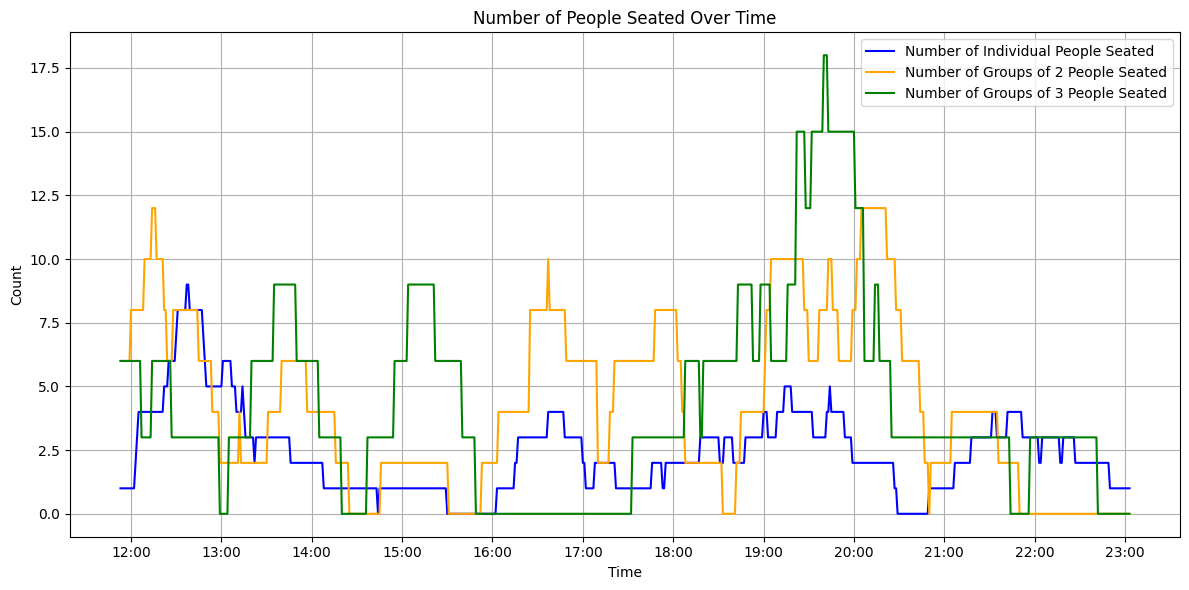

In [6]:
warnings.filterwarnings("ignore")
chosen_day = '2015-11-26'

filtered_df_1 = df[(df['date'] == chosen_day) & (df['Number_of_people_seated'] == 1)]
filtered_df_2 = df[(df['date'] == chosen_day) & (df['Number_of_people_seated'] == 2)]
filtered_df_3 = df[(df['date'] == chosen_day) & (df['Number_of_people_seated'] == 3)]

for filtered_df in [filtered_df_1, filtered_df_2, filtered_df_3]:
    filtered_df["start_time"] = pd.to_datetime(filtered_df["start_time"])
    filtered_df["end_time"] = pd.to_datetime(filtered_df["end_time"])

min_time = filtered_df_1["start_time"].min()
max_time = filtered_df_1["end_time"].max()
time_range = pd.date_range(start=min_time, end=max_time, freq='T')

time_counts_1 = pd.DataFrame({"time": time_range, "count": 0})
time_counts_2 = pd.DataFrame({"time": time_range, "count": 0})
time_counts_3 = pd.DataFrame({"time": time_range, "count": 0})

for _, row in filtered_df_1.iterrows():
    mask = (time_counts_1["time"] >= row["start_time"]) & (time_counts_1["time"] <= row["end_time"])
    time_counts_1.loc[mask, "count"] += row["Number_of_people_seated"]

for _, row in filtered_df_2.iterrows():
    mask = (time_counts_2["time"] >= row["start_time"]) & (time_counts_2["time"] <= row["end_time"])
    time_counts_2.loc[mask, "count"] += row["Number_of_people_seated"]

for _, row in filtered_df_3.iterrows():
    mask = (time_counts_3["time"] >= row["start_time"]) & (time_counts_3["time"] <= row["end_time"])
    time_counts_3.loc[mask, "count"] += row["Number_of_people_seated"]

plt.figure(figsize=(12, 6))
plt.plot(time_counts_1["time"], time_counts_1["count"], label="Number of Individual People Seated", color="blue")
plt.plot(time_counts_2["time"], time_counts_2["count"], label="Number of Groups of 2 People Seated", color="orange")
plt.plot(time_counts_3["time"], time_counts_3["count"], label="Number of Groups of 3 People Seated", color="green")

hourly_ticks = time_counts_1["time"][time_counts_1["time"].dt.minute == 0]
plt.xticks(
    hourly_ticks,  
    hourly_ticks.dt.strftime('%H:%M'), 
)
plt.title("Number of People Seated Over Time")
plt.xlabel("Time")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The line chart shows the seating patterns on November 26, 2015, highlighting activity for individual diners, groups of two, and groups of three throughout the day. There is steady activity from morning until late evening, with noticeable spikes in group seatings during lunch and dinner hours.

We are going to be analyzing the customer traffic (seating capacity) for every 5 minute interval

In [7]:
unique_dates = df['date'].unique()

start_time = df.start_time.min().strftime('%H:%M:%S')
end_time = df.start_time.max().strftime('%H:%M:%S')
time_range = pd.date_range(start=start_time, end=end_time, freq="5T").strftime("%H:%M").tolist()

In [8]:
def get_value_counts_for_time_range_multiple_with_columns(df, dates, start_times):
    
    """
    Calculating the value counts of 'Number_of_people_seated' for multiple dates and start times.
    Parameters:
    df (pd.DataFrame): DataFrame containing the data with 'start_time', 'end_time', and 'Number_of_people_seated' columns.
    dates (list of str): List of date strings to process.
    start_times (list of str): List of start time strings to process.
    Returns:
    pd.DataFrame: DataFrame with the value counts of 'Number_of_people_seated' for each date and start time.
                  The DataFrame includes columns for the day of the week, date, time, and counts of people seated.
    """
    
    results = []
    
    for date in dates:
        
        day_of_week = pd.to_datetime(date).day_name() 
        
        clear_output(wait=True)
        print(date)
        
        for start_time in start_times:
            
            start_time_dt = pd.to_datetime(f"{date} {start_time}")
            filtered_rows = df[
                (df['start_time'] <= start_time_dt) & (df['end_time'] > start_time_dt)
            ]
            
            value_counts = filtered_rows['Number_of_people_seated'].value_counts()
            row = {'day_of_week': day_of_week, 'date': date, 'time': start_time_dt.time()}
            
            for seat_value in sorted(df['Number_of_people_seated'].unique()):
                row[f"Seated_{seat_value}"] = value_counts.get(seat_value, 0)
            
            results.append(row)

    return pd.DataFrame(results)

seating_data_regression = get_value_counts_for_time_range_multiple_with_columns(df, unique_dates, time_range)
seating_data_regression['date'] = pd.to_datetime(seating_data_regression['date'])
seating_data_regression ['Season'] = seating_data_regression['date'].dt.month.map(season_mapping)

seating_data_regression = seating_data_regression[['Season', 'day_of_week'] + [col for col in seating_data_regression.columns if col not in ['Season', 'day_of_week']]]

2015-12-27


In [9]:
seating_data_regression

,Season,day_of_week,date,time,Seated_1,Seated_2,Seated_3,Seated_4,Seated_5,Seated_6,Seated_7,Seated_8,Seated_9,Seated_10,Seated_11,Seated_12,Seated_13,Seated_14,Seated_15
0,Winter,Thursday,2015-01-01,11:38:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Winter,Thursday,2015-01-01,11:43:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Winter,Thursday,2015-01-01,11:48:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Winter,Thursday,2015-01-01,11:53:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Winter,Thursday,2015-01-01,11:58:00,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43891,Winter,Sunday,2015-12-27,21:33:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43892,Winter,Sunday,2015-12-27,21:38:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43893,Winter,Sunday,2015-12-27,21:43:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43894,Winter,Sunday,2015-12-27,21:48:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The table above details the number of different group sizes present in the store at each 5-minute interval. For instance, at 11:58 on January 1, 2015 (index 4), there is one individual seated at a table and another group of five people seated at a different table.

Now we plot frequency plots for each column to understand the distribution of the columns so that we can bin them accurately at a later stage.

### Frequency Plots

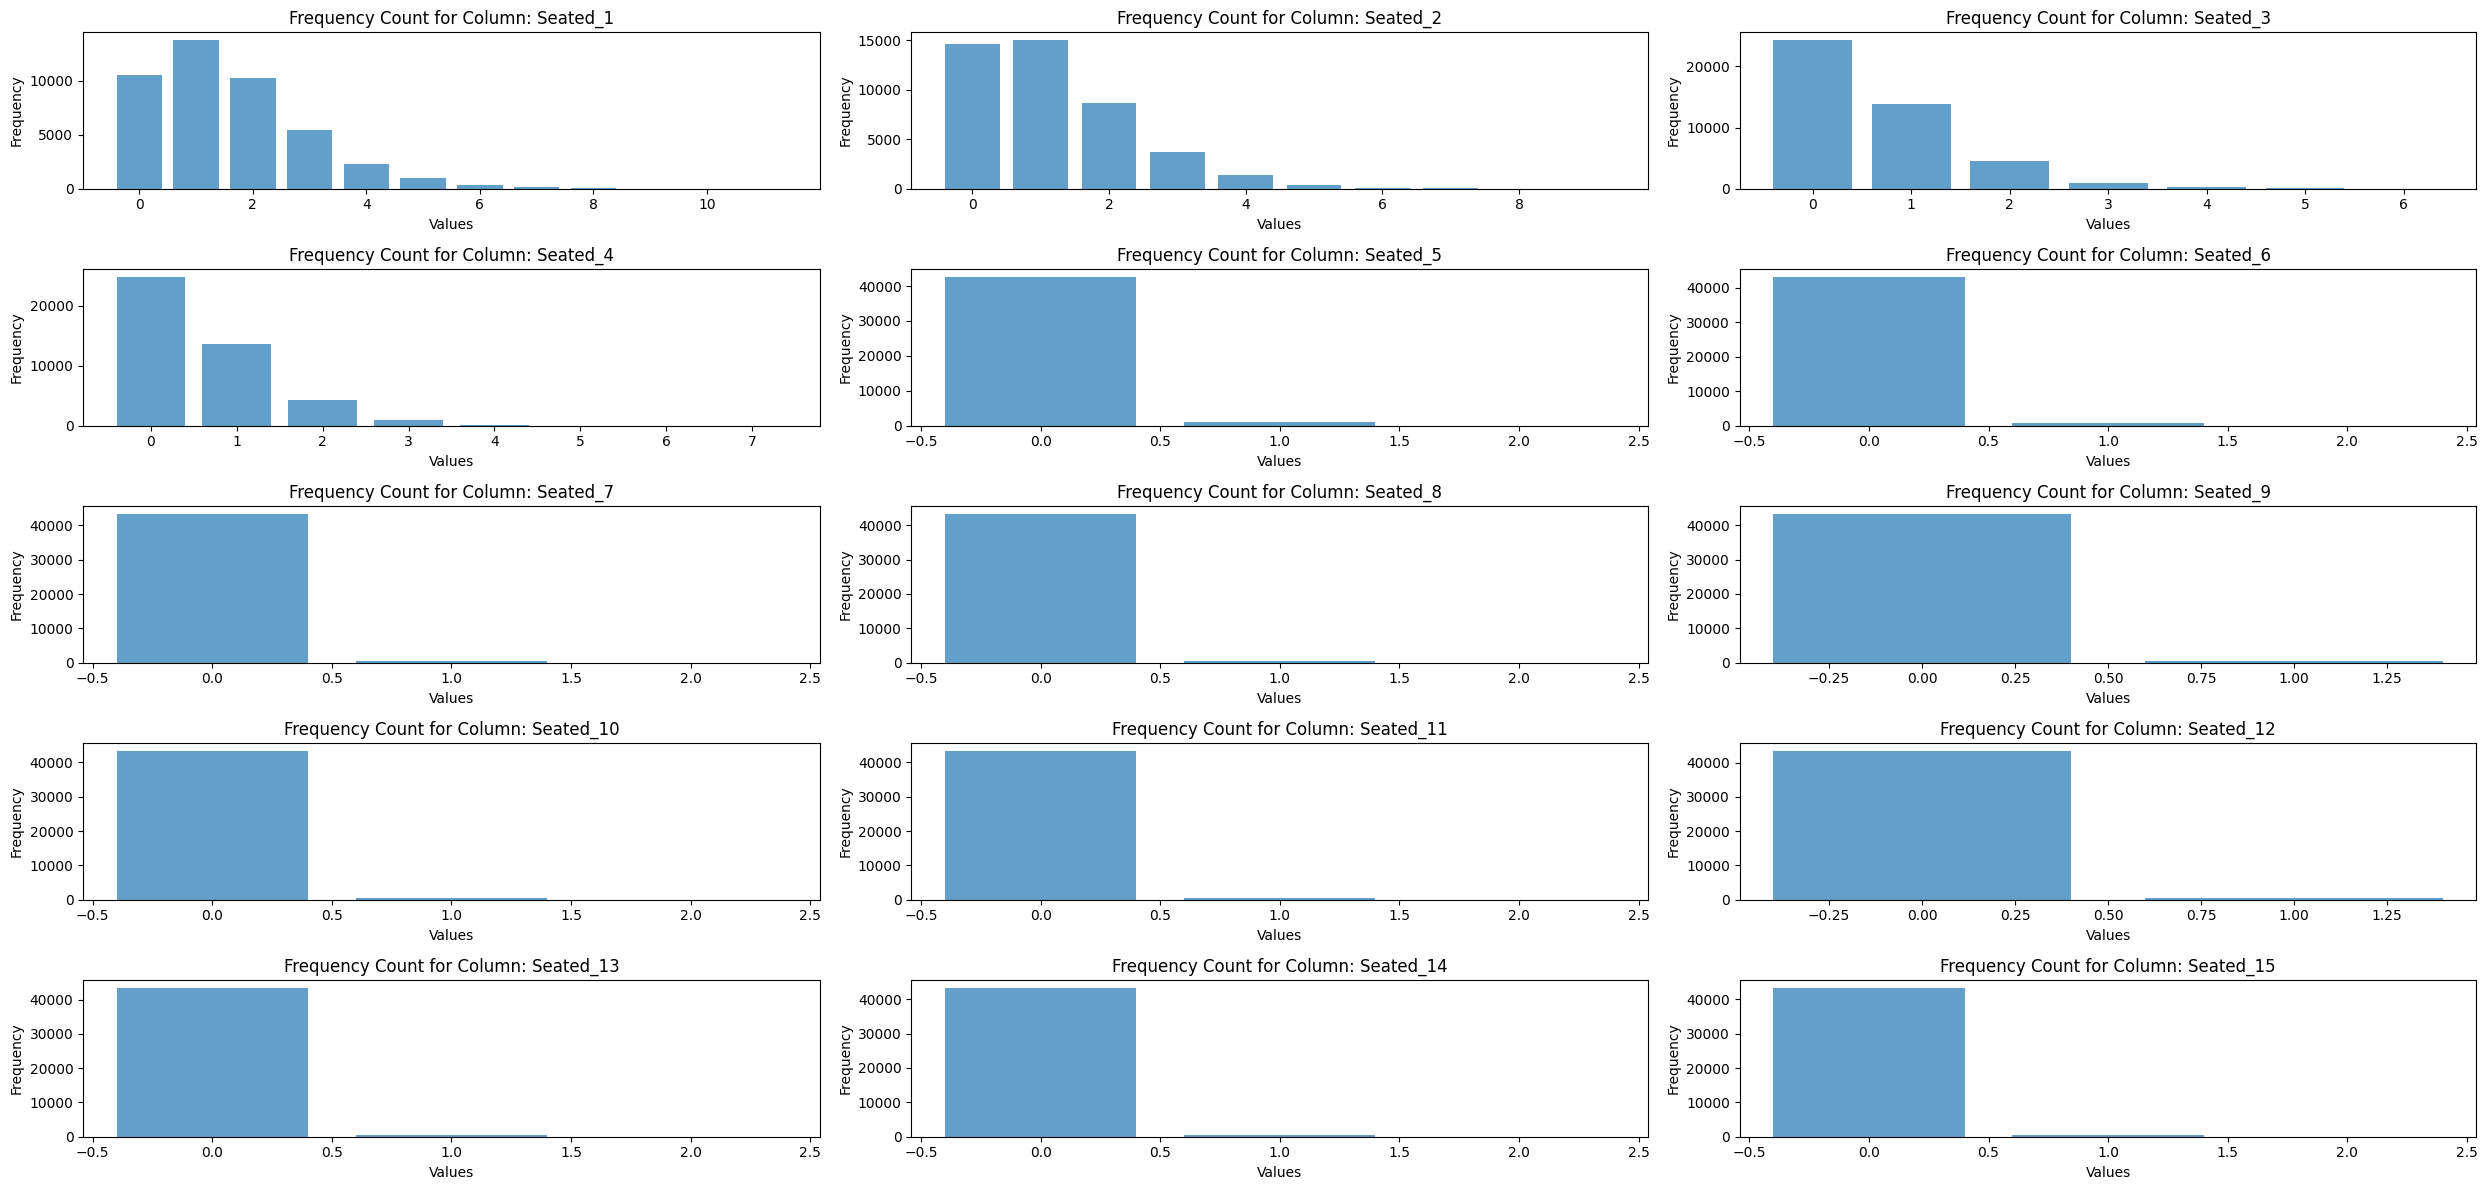

In [20]:
num_plots = len([col for col in seating_data_regression.columns 
                 if col not in ['date', 'time', 'Season', 'day_of_week', 'hour', 'minute', 'month', 'day']])

rows = math.ceil(num_plots / 3)
cols = 3

fig, ax = plt.subplots(figsize=(25, 12), nrows=rows, ncols=cols)

ax = ax.reshape(rows, cols) if rows > 1 else [ax]

plot_idx = 0
for column in seating_data_regression.columns:
    if column not in ['date', 'time', 'Season', 'day_of_week', 'hour', 'minute', 'month', 'day']:
        r, c = divmod(plot_idx, 3)
        ax[r][c].bar(seating_data_regression[column].value_counts().index,
                     seating_data_regression[column].value_counts().values,
                     alpha=0.7)
        ax[r][c].set_title(f"Frequency Count for Column: {column}")
        ax[r][c].set_xlabel("Values")
        ax[r][c].set_ylabel("Frequency")
        plot_idx += 1

for i in range(plot_idx, rows * cols):
    fig.delaxes(ax[i // 3][i % 3])

plt.tight_layout()
plt.show()


After analyzing the frequency plots, it is clear that the pizza store is visited most commonly by individual customers, groups of 2, 3 or 4 and rarely by groups of more than 4 customers. Therefore, we decided to club the groups that have more than 4 customers into a column called seated_4+

# CLASSIFICATION

We are going to bin the seating columns to "Low", "Medium", and "High" bins indicated the appropriate intensity of customer traffic for that specific column

In [21]:
def classify_seating(value, seat_type):
    
    if seat_type == 1:
        if 0 <= value <= 2:
            return 'Low'
        elif 2 < value <= 4:
            return 'Medium'
        else:
            return 'High'
    elif seat_type == 2:
        if 0 <= value <= 1:
            return 'Low'
        elif 1 < value <= 3:
            return 'Medium'
        else:
            return 'High'
    elif seat_type in [3, 4]:
        if 0 <= value <= 1:
            return 'Low'
        elif 1 < value < 3:
            return 'Medium'
        else:
            return 'High'
    elif seat_type == '4+':
        if 0 <= value <= 1:
            return 'Low'
        else:
            return 'High'

In [22]:
def get_value_counts_for_time_range_multiple_with_columns(df, dates, start_times):
    
    """
    Calculate the value counts of the number of people seated within specified time ranges for multiple dates.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data with columns 'start_time', 'end_time', and 'Number_of_people_seated'.
    dates (list of str): List of dates (in 'YYYY-MM-DD' format) for which to calculate the value counts.
    start_times (list of str): List of start times (in 'HH:MM:SS' format) for which to calculate the value counts.

    Returns:
    pd.DataFrame: DataFrame containing the value counts of the number of people seated for each date and time range.
                  The DataFrame includes columns for the day of the week, date, time, and counts of people seated (1, 2, 3, 4, and 4+).
    """

    results = []

    for date in dates:
        day_of_week = pd.to_datetime(date).day_name()
        clear_output(wait=True)
        print(date)

        for start_time in start_times:
            start_time_dt = pd.to_datetime(f"{date} {start_time}")
            filtered_rows = df[
                (df['start_time'] <= start_time_dt) & (df['end_time'] > start_time_dt)
            ]

            value_counts = filtered_rows['Number_of_people_seated'].value_counts()

            row = {'day_of_week': day_of_week, 'date': date, 'time': start_time_dt.time()}

            row['Seated_1'] = value_counts.get(1, 0)
            row['Seated_2'] = value_counts.get(2, 0)
            row['Seated_3'] = value_counts.get(3, 0)
            row['Seated_4'] = value_counts.get(4, 0)

            row['Seated_4+'] = sum(count for value, count in value_counts.items() if value > 4)

            results.append(row)

    return pd.DataFrame(results)

seating_data_classification = get_value_counts_for_time_range_multiple_with_columns(df, unique_dates, time_range)
seating_data_classification['date'] = pd.to_datetime(seating_data_classification['date'])
seating_data_classification['Season'] = seating_data_classification['date'].dt.month.map(season_mapping)

seating_data_classification['Seated_1'] = seating_data_classification['Seated_1'].apply(lambda x: classify_seating(x, 1))
seating_data_classification['Seated_2'] = seating_data_classification['Seated_2'].apply(lambda x: classify_seating(x, 2))
seating_data_classification['Seated_3'] = seating_data_classification['Seated_3'].apply(lambda x: classify_seating(x, 3))
seating_data_classification['Seated_4'] = seating_data_classification['Seated_4'].apply(lambda x: classify_seating(x, 4))
seating_data_classification['Seated_4+'] = seating_data_classification['Seated_4+'].apply(lambda x: classify_seating(x, '4+'))

seating_data_classification = seating_data_classification[['Season', 'day_of_week'] + [col for col in seating_data_classification.columns if col not in ['Season', 'day_of_week']]]

2015-12-27


Creating the dataset for classification (binned seating columns)

In [23]:
seating_data_classification.sample(20)

,Season,day_of_week,date,time,Seated_1,Seated_2,Seated_3,Seated_4,Seated_4+
19891,Summer,Wednesday,2015-06-10,15:53:00,Low,Low,Low,Low,Low
29757,Fall,Friday,2015-08-28,21:43:00,Low,Medium,Low,Low,Low
33528,Fall,Wednesday,2015-09-30,15:38:00,Low,Low,Low,Low,Low
13274,Spring,Saturday,2015-04-18,12:08:00,Low,Low,Low,Low,Low
43266,Winter,Monday,2015-12-21,21:08:00,Low,Low,Low,Low,Low
17782,Summer,Sunday,2015-05-24,15:48:00,Low,Medium,Low,Low,Low
5590,Winter,Sunday,2015-02-15,12:28:00,Low,Medium,Low,Low,Low
7227,Winter,Saturday,2015-02-28,14:33:00,Medium,Low,Low,Low,Low
2513,Winter,Wednesday,2015-01-21,14:23:00,Low,Medium,Low,Low,Low
36246,Fall,Sunday,2015-10-25,14:48:00,Medium,Low,Medium,Low,Low


In [24]:
# Preparing the data for classification
seating_data_classification['hour'] = seating_data_classification['time'].apply(lambda x: x.hour)
seating_data_classification['minute'] = seating_data_classification['time'].apply(lambda x: x.minute)
seating_data_classification['month'] = pd.to_datetime(seating_data_classification['date']).dt.month
seating_data_classification['day'] = pd.to_datetime(seating_data_classification['date']).dt.day

features = ['Season', 'day_of_week', 'month', 'day', 'hour', 'minute']
targets = [col for col in seating_data_classification.columns if col.startswith('Seated_')]

X = seating_data_classification[features]
y = seating_data_classification[targets]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['Season', 'day_of_week']
numerical_features = ['month', 'day', 'hour', 'minute']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

results = {}
combined_report = []

## RandomForestClassifier

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

results = {}
combined_report = []

for target in targets:
    print(f"Training model for target: {target}")
    y_train_target = y_train[target]
    y_test_target = y_test[target]

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train_target)

    best_model = grid_search.best_estimator_
    print(f"Best parameters for {target}: {grid_search.best_params_}")

    y_pred_target = best_model.predict(X_test)
    accuracy = accuracy_score(y_test_target, y_pred_target)
    print(f"Accuracy for {target}: {accuracy}\n")
    report = classification_report(y_test_target, y_pred_target, zero_division=0)
    results[target] = report
    combined_report.append(f"Classification Report for {target}:\n{report}\n")

for target, report in results.items():
    print(f"Classification Report for {target}:\n{report}\n")

Training model for target: Seated_1
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Seated_1: {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 150}
Accuracy for Seated_1: 0.8771070615034169

Training model for target: Seated_2
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Seated_2: {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 150}
Accuracy for Seated_2: 0.8555808656036447

Training model for target: Seated_3
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Seated_3: {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 150}
Accuracy for Seated_3: 0.9211845102505695

Training model for target: Seated_4
Fitting 5 folds for each of 108 candidates, to

### Classification summary for Seated_1

Accuracy: 87.71%

Observations:

The model performs strongly overall, particularly for the 'Low' category, with recall (0.98) and F1-score (0.94) highlighting its reliability.

Challenges are observed in predicting 'High' and 'Medium' categories, with relatively lower recall (0.50 and 0.49, respectively), likely due to the significant class imbalance.

Despite the imbalance, the weighted average metrics showcase the model's robustness in handling the dominant 'Low' category effectively while maintaining fair performance for minority classes.

### Classifcation summary for Groups of 2

Accuracy: 85.56%

Observations:

High recall for the 'Low' category (0.95) demonstrates the model's consistency in identifying minimal traffic.

Improved recall for the 'Medium' category (0.69) compared to Seated_1 highlights better adaptability to this specific target's distribution.

The imbalance between class sizes poses challenges for the 'High' category, but the model still achieves reasonable precision (0.78).

### Classifcation summary for groups of 3

Accuracy: 92.12%

Observations:

Exceptional performance in predicting the 'Low' category, with recall (0.99) and F1-score (0.96) reflecting strong reliability.

The 'Medium' and 'High' categories show reduced recall (0.43 and 0.53, respectively), though precision remains robust for these classes.

The dominant class ('Low') is predicted effectively, with class imbalance being managed well overall.

### Classifcation summary for groups of 4

Accuracy: 92.74%

Observations:

The model excels in predicting the 'Low' category, achieving high precision (0.94) and recall (0.99).

Performance for the 'Medium' category remains lower (recall 0.44), consistent with challenges posed by class imbalance.

The overall accuracy and weighted averages underscore the model's strong performance for the dominant class.

### Classifcation summary for Groups of 5 or more

Accuracy: 98.94%

Observations:

Outstanding performance for the 'Low' category, with metrics nearing perfection (precision, recall, and F1-score close to 1.00).

The 'High' category demonstrates strong precision (0.93), though recall (0.58) is lower, reflecting some challenges with the minority class.

The significant skew in class distribution is handled exceptionally well, resulting in near-perfect accuracy for the majority class.

### Key Insights

* The model performs exceptionally well for the 'Low' category across all targets, with consistently high precision, recall, and F1-scores.
* Predicting 'High' and 'Medium' categories is more challenging, with lower recall, though precision is generally robust.
* As the group size increases, accuracy and weighted averages improve, peaking at Seated_4+.
* The class imbalance in the dataset is effectively managed, allowing strong performance for the dominant 'Low' class while maintaining fair results for minority classes.

## DecisionTreeClassifier

In [26]:
param_grid = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

results = {}
combined_report = []

for target in targets:
    print(f"Training model for target: {target}")
    y_train_target = y_train[target]
    y_test_target = y_test[target]

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train_target)

    best_model = grid_search.best_estimator_
    print(f"Best parameters for {target}: {grid_search.best_params_}")

    y_pred_target = best_model.predict(X_test)
    accuracy = accuracy_score(y_test_target, y_pred_target)
    print(f"Accuracy for {target}: {accuracy}\n")
    report = classification_report(y_test_target, y_pred_target, zero_division=0)
    results[target] = report
    combined_report.append(f"Classification Report for {target}:\n{report}\n")

for target, report in results.items():
    print(f"Classification Report for {target}:\n{report}\n")

Training model for target: Seated_1
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for Seated_1: {'classifier__criterion': 'gini', 'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Accuracy for Seated_1: 0.883371298405467

Training model for target: Seated_2
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for Seated_2: {'classifier__criterion': 'gini', 'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Accuracy for Seated_2: 0.8542141230068337

Training model for target: Seated_3
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for Seated_3: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Accuracy for Seated_3: 0.9261958997722096

Training model for target: Seated_4
Fitting 5 folds for each of 72 candidates, total

### Classification summary for Individual Customers

Accuracy: 88.34%

Observations:

The model performs strongly for the 'Low' category, with precision, recall, and F1-score all at 0.94, showcasing its reliability for the dominant class.

Performance for the 'High' and 'Medium' categories is balanced, with F1-scores of 0.66 and 0.68, respectively, reflecting the model's ability to manage minority classes effectively.

The class imbalance, heavily skewed toward the 'Low' category, has been effectively handled, resulting in strong overall performance.

### Classification summary for Groups of 2

Accuracy: 85.42%

Observations:

High recall for the 'Low' category (0.91) highlights the model’s ability to predict minimal traffic consistently.

The 'Medium' category shows good balance with an F1-score of 0.75, indicating reliable performance for this class.

The model effectively maintains balanced predictions across all categories, showcasing robust handling of class imbalance.

### Classification summary for Groups of 3

Accuracy: 92.62%

Observations:

Outstanding performance for the 'Low' category, with precision (0.97), recall (0.96), and F1-score (0.96), demonstrating exceptional reliability.

The 'Medium' category maintains reasonable performance, with an F1-score of 0.66, reflecting fair results for minority classes.

The model handles increasing group sizes effectively, maintaining high accuracy and balanced performance across all categories.

### Classification summary for Groups of 4

Accuracy: 92.44%

Observations:

Exceptional metrics for the 'Low' category, with precision (0.96), recall (0.96), and F1-score (0.96), indicating reliable predictions for the dominant class.

The 'Medium' category shows fair performance, with an F1-score of 0.63, demonstrating balanced handling of minority classes despite the class imbalance.

The model’s robust performance across all categories highlights its adaptability to larger group sizes.

### Classification summary for Groups of 5 or more

Accuracy: 98.68%

Observations:

Near-perfect metrics for the 'Low' category, with precision, recall, and F1-scores close to 1.00, showcasing the model’s reliability for the dominant class.

The 'High' category shows strong precision (0.72) and reasonable recall (0.68), ensuring balanced predictions for minority classes.

The model incorporates the class imbalance exceptionally well, achieving near-perfect accuracy for the majority class while maintaining fair results for minority categories.

### Key Insights

The decision tree model demonstrates excellent performance for the 'Low' category across all group sizes, with consistently high precision, recall, and F1-scores.

Predictions for 'High' and 'Medium' categories, while more challenging, remain balanced and reliable, particularly as group sizes increase.

Accuracy and weighted average metrics improve with larger group sizes, peaking at Seated_4+.

The significant class imbalance in the dataset has been effectively managed, ensuring strong performance for the dominant 'Low' category while maintaining reasonable results for minority classes.

### Random Forest vs. Decision Tree Comparison

Both the random forest and decision tree models excel at predicting the dominant 'Low' traffic category due to the significant class imbalance in the dataset. However, the random forest model consistently outperforms the decision tree in terms of overall accuracy and weighted metrics, particularly for larger group sizes. While the decision tree provides balanced performance and interpretable results, the random forest’s ensemble approach enhances precision and recall for minority classes, resulting in more robust predictions across all categories and group sizes.

Given the strengths of both models, combining them through a voting classifier could further enhance performance by leveraging their complementary advantages.

## VotingClassifier

In [27]:
classifiers = [
    ('logistic', LogisticRegression(random_state=42)),
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('random_forest', RandomForestClassifier(random_state=42))
]

param_grid = {
    'classifier__logistic__C': [0.1, 1, 10],
    'classifier__decision_tree__max_depth': [None, 10, 20],
    'classifier__decision_tree__min_samples_split': [2, 5],
    'classifier__random_forest__n_estimators': [50, 100, 150],
    'classifier__random_forest__max_depth': [None, 10, 20],
}

results = {}
combined_report = []
models = {}

for target in targets:
    print(f"Training model for target: {target}")
    y_train_target = y_train[target]
    y_test_target = y_test[target]

    voting_classifier = VotingClassifier(estimators=classifiers, voting='soft')
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', voting_classifier)
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train_target)

    best_model = grid_search.best_estimator_
    models[target] = best_model
    print(f"Best parameters for {target}: {grid_search.best_params_}")

    y_pred_target = best_model.predict(X_test)
    accuracy = accuracy_score(y_test_target, y_pred_target)
    print(f"Accuracy for {target}: {accuracy}\n")

    report = classification_report(y_test_target, y_pred_target, zero_division=0)
    results[target] = report
    combined_report.append(f"Classification Report for {target}:\n{report}\n")

for target, report in results.items():
    print(f"Classification Report for {target}:\n{report}\n")

Training model for target: Seated_1
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters for Seated_1: {'classifier__decision_tree__max_depth': None, 'classifier__decision_tree__min_samples_split': 2, 'classifier__logistic__C': 10, 'classifier__random_forest__max_depth': None, 'classifier__random_forest__n_estimators': 150}
Accuracy for Seated_1: 0.8907744874715262

Training model for target: Seated_2
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters for Seated_2: {'classifier__decision_tree__max_depth': None, 'classifier__decision_tree__min_samples_split': 2, 'classifier__logistic__C': 0.1, 'classifier__random_forest__max_depth': None, 'classifier__random_forest__n_estimators': 150}
Accuracy for Seated_2: 0.8634396355353076

Training model for target: Seated_3
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters for Seated_3: {'classifier__decision_tree__max_depth': None, 'classifier__decision_tree__min_s

### Performance for Individual Customers (Seated_1)

Accuracy: 89.08%

Observations:

The model performs strongly for the 'Low' category, with precision and recall both above 0.90, resulting in an F1-score of 0.94.

Performance for the 'High' and 'Medium' categories is balanced, with F1-scores of 0.67, demonstrating the classifier's ability to handle less common categories.

The voting classifier shows improved reliability compared to individual classifiers, especially in managing class imbalance.

### Performance for Groups of 2 (Seated_2)

Accuracy: 86.34%

Observations:

The 'Low' category is predicted consistently, with precision and recall both exceeding 0.90, yielding an F1-score of 0.92.

The 'Medium' category achieves an F1-score of 0.75, reflecting better balance in predictions across categories.

The classifier demonstrates robustness in handling class imbalance, providing reliable results for all categories.

### Performance for Groups of 3 (Seated_3)

Accuracy: 93.10%

Observations:

The model achieves excellent results for the 'Low' category, with F1-scores close to 0.97, highlighting strong performance for the dominant class.

Recall for the 'High' and 'Medium' categories improves, making predictions more balanced than with individual classifiers.

The voting classifier proves effective across varying group sizes, ensuring robust performance.

### Performance for Groups of 4 (Seated_4)

Accuracy: 93.49%

Observations:

Exceptional performance for the 'Low' category, with recall and F1-scores near 0.97.

The 'High' and 'Medium' categories show improvement, with F1-scores of 0.69 and 0.63, reflecting better balance in predictions for minority classes.

The model handles varying class distributions effectively, providing consistent results across categories.

### Performance for Groups of 5 or More (Seated_4+)

Accuracy: 98.80%

Observations:

Nearly perfect results for the 'Low' category, with F1-scores close to 0.99, demonstrating exceptional reliability.

The 'High' category improves, with precision at 0.90 and an F1-score of 0.67, showing better handling of minority classes.

The voting classifier maintains high performance across all categories, effectively managing class imbalance.

### Key Insights

The voting classifier outperforms individual classifiers, particularly in predicting less common categories like 'High' and 'Medium.'

It improves precision, recall, and F1-scores for minority classes while maintaining excellent accuracy for the dominant 'Low' class.

Accuracy increases with group size, peaking at 98.80% for Seated_4+.

The classifier demonstrates robust handling of class imbalance, making it a reliable and effective model for this task.

In [28]:
random_data = []
random_test_data = []

for _ in range(100):

    random_date = pd.Timestamp(f"2016-{random.randint(1, 12):02d}-{random.randint(1, 28):02d}")
    random_time_delta = random.randint(
        0, int((datetime.strptime(end_time, "%H:%M:%S") - datetime.strptime(start_time, "%H:%M:%S")).total_seconds())
    )
    
    start_time_obj = datetime(1900, 1, 1, 11, 38, 36)

    random_time = (start_time_obj + timedelta(seconds=random_time_delta)).time()
    hour = random_time.hour
    minute = random_time.minute

    random_data.append({
        'date': random_date,
        'time': f'{hour}:{minute}'
    })

    day_of_week = pd.to_datetime(random_date).day_name()
    month = random_date.month
    season = season_mapping[month]
    day = random_date.day
    
    random_test_data.append({
        'Season': season,
        'day_of_week': day_of_week,
        'month': month,
        'day': day,
        'hour': hour,
        'minute': minute,
    })

random_test_df = pd.DataFrame(random_test_data)
random_df = pd.DataFrame(random_data)
for target, model in models.items():
    random_df[target] = model.predict(random_test_df)

In [29]:
random_df

,date,time,Seated_1,Seated_2,Seated_3,Seated_4,Seated_4+
0,2016-11-11,21:32,Low,Medium,Low,Low,Low
1,2016-03-09,14:1,Medium,Low,Low,Low,Low
2,2016-12-01,15:9,Low,Low,Low,Low,Low
3,2016-06-25,15:3,Low,Low,Low,Low,Low
4,2016-03-12,13:45,Low,Low,Low,Low,Low
...,...,...,...,...,...,...,...
95,2016-05-23,12:56,Low,Medium,Low,Low,High
96,2016-02-03,17:47,Low,High,Low,Low,Low
97,2016-05-17,20:34,Low,Low,Low,Low,Low
98,2016-01-11,16:17,Low,Medium,Low,Low,Low


## Project Analysis Note 

While we initially focused on classification as the primary method for this part of the project, our interest in the data led us to explore additional approaches. After working on the project for the past month, we decided to take a more comprehensive look at the business needs of the store. Although classification remains our main priority, we also applied regression techniques and clustering to gain a deeper understanding and provide a more complete solution for the store.

#### Regression Analysis for more granular analysis
As a pizza store manager, they might need more granular data to efficiently run their business and understand customer traffic. Therefore, to help them out further we also provided them with a regression analysis so that the store can rely on actual numbers to understand exactly how many groups are expected at any given 5 minute interval.

In [30]:
# Training and evaluating a RandomForestRegressor model for seating data prediction
seating_data_regression['hour'] = seating_data_regression['time'].apply(lambda x: x.hour)
seating_data_regression['minute'] = seating_data_regression['time'].apply(lambda x: x.minute)
seating_data_regression['month'] = pd.to_datetime(seating_data_regression['date']).dt.month
seating_data_regression['day'] = pd.to_datetime(seating_data_regression['date']).dt.day

features = ['Season', 'day_of_week', 'month', 'day', 'hour', 'minute']
targets = [col for col in seating_data_regression.columns if col.startswith('Seated_')]

X = seating_data_regression[features]
y = seating_data_regression[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['Season', 'day_of_week']
numerical_features = ['month', 'day', 'hour', 'minute']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

regression_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

regression_model.fit(X_train, y_train)

y_pred = regression_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.08500599848139641


From the mean absolute error we can see that the regressor is fitting the data well with a very low MAE score. Let's see how the model does on unseen data.

#### Test Regression

In [31]:
# Creating random subsets from test dataset to predict the seating data

random_data = []
random_test_data = []

for _ in range(100):

    random_date = pd.Timestamp(f"2016-{random.randint(1, 12):02d}-{random.randint(1, 28):02d}")
    random_time_delta = random.randint(
        0, int((datetime.strptime(end_time, "%H:%M:%S") - datetime.strptime(start_time, "%H:%M:%S")).total_seconds())
    )

    start_time_obj = datetime(1900, 1, 1, 11, 38, 36)

    random_time = (start_time_obj + timedelta(seconds=random_time_delta)).time()
    hour = random_time.hour
    minute = random_time.minute

    random_data.append({
        'date': random_date,
        'time': f'{hour}:{minute}'
    })

    day_of_week = pd.to_datetime(random_date).day_name()
    month = random_date.month
    season = season_mapping[month]
    day = random_date.day
    
    random_test_data.append({
        'Season': season,
        'day_of_week': day_of_week,
        'month': month,
        'day': day,
        'hour': hour,
        'minute': minute,
    })

random_test_df = pd.DataFrame(random_test_data)
random_df = pd.DataFrame(random_data)

predictions = regression_model.predict(random_test_df)
num_pred_columns = predictions.shape[1]
predicted_df = pd.DataFrame(predictions, columns=[f'Seated_{i+1}' for i in range(num_pred_columns)])

result_df = pd.concat([random_df, predicted_df], axis=1)
result_df['Total'] = sum(result_df[f'Seated_{i}'] * i for i in range(1, 16))
result_df

,date,time,Seated_1,Seated_2,Seated_3,Seated_4,Seated_5,Seated_6,Seated_7,Seated_8,Seated_9,Seated_10,Seated_11,Seated_12,Seated_13,Seated_14,Seated_15,Total
0,2016-01-17,16:20,1.06,1.15,1.72,0.09,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,8.88
1,2016-12-17,18:29,1.91,1.19,0.87,0.75,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,9.90
2,2016-05-23,18:50,1.62,1.48,0.44,0.76,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,8.94
3,2016-11-15,16:30,0.27,1.26,0.91,0.57,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,7.80
4,2016-04-23,14:25,2.51,1.50,0.21,0.56,0.00,0.14,0.35,0.01,0.02,0.0,0.0,0.00,0.0,0.00,0.01,12.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2016-09-14,18:33,0.60,1.62,0.78,0.31,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,7.42
96,2016-09-10,16:8,1.69,0.33,1.32,0.09,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,6.67
97,2016-05-19,13:32,3.27,1.95,0.89,0.36,0.13,0.00,0.00,0.00,0.01,0.0,0.4,0.22,0.0,0.01,0.00,19.20
98,2016-07-07,19:37,0.66,1.07,0.31,0.83,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,7.05


These kinds of predictions, we believe, gives the store manager accurate and more granual information (if they choose to use it) to prepare for the upcoming day.

# Clustering Analysis

In [32]:
df = pd.read_csv("Final_PWT_data.csv")

For the clustering section of this project, we plan to cluster the different days in the calendar year to see if there are days that can be grouped into clusters and further analyzed to help the pizza store prepare ingredients and such for those days depending on demand

Therefore, we are going to prepare the dataset in such a way that we aggregate sales for each singular day and try to understand how many pizzas, what kinds of pizzas, the size of the pizzas sold on any given day and subsequently find the total sales for each day. 

In [33]:
# Grouping the data by date and corresponding column to aggregate for clustering

gr_size = df.groupby(["date", "size"]).size().reset_index().pivot_table(index="date", columns="size", values=0, fill_value=0).reset_index()
gr_category = df.groupby(["date", "category"]).size().reset_index().pivot_table(index="date", columns="category", values=0, fill_value=0).reset_index()
gr_price = df.groupby(["date"])['price'].sum().reset_index()

In [34]:
gr_pizza_size = df.groupby(["date","category","size"]).size().reset_index()
gr_pizza_size['pizza_size'] = gr_pizza_size['category'].astype(str) + "_" + gr_pizza_size['size']
gr_pizza_size = gr_pizza_size.pivot_table(index="date", columns="pizza_size", values=0, fill_value=0).reset_index()

In [35]:
# Merging the dataframes on the 'date' column
gr_combined = gr_size.merge(gr_category, on='date') \
                     .merge(gr_price, on='date') \
                     .merge(gr_pizza_size, on='date')

In [36]:
pd.set_option('display.max_columns', None)

In [37]:
gr_combined

,date,L,M,S,XL,XXL,Chicken,Classic,Supreme,Veggie,price,Chicken_L,Chicken_M,Chicken_S,Classic_L,Classic_M,Classic_S,Classic_XL,Classic_XXL,Supreme_L,Supreme_M,Supreme_S,Veggie_L,Veggie_M,Veggie_S
0,2015-01-01,71.0,47.0,42.0,1.0,0.0,36.0,46.0,39.0,40.0,2697.85,21.0,10.0,5.0,12.0,15.0,18.0,1.0,0.0,16.0,15.0,8.0,22.0,7.0,11.0
1,2015-01-02,74.0,35.0,50.0,1.0,0.0,31.0,55.0,43.0,31.0,2643.15,12.0,10.0,9.0,18.0,12.0,24.0,1.0,0.0,24.0,8.0,11.0,20.0,5.0,6.0
2,2015-01-03,62.0,51.0,37.0,4.0,0.0,39.0,46.0,32.0,37.0,2596.15,21.0,11.0,7.0,10.0,14.0,18.0,4.0,0.0,11.0,13.0,8.0,20.0,13.0,4.0
3,2015-01-04,39.0,36.0,31.0,0.0,0.0,28.0,26.0,28.0,24.0,1755.45,13.0,11.0,4.0,9.0,8.0,9.0,0.0,0.0,9.0,9.0,10.0,8.0,8.0,8.0
4,2015-01-05,44.0,45.0,32.0,0.0,0.0,27.0,37.0,28.0,29.0,1994.95,9.0,16.0,2.0,10.0,8.0,19.0,0.0,0.0,10.0,10.0,8.0,15.0,11.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,2015-12-22,45.0,37.0,29.0,0.0,0.0,28.0,26.0,25.0,32.0,1834.70,11.0,10.0,7.0,7.0,7.0,12.0,0.0,0.0,9.0,9.0,7.0,18.0,11.0,3.0
350,2015-12-23,56.0,33.0,39.0,2.0,0.0,27.0,47.0,28.0,28.0,2175.30,20.0,4.0,3.0,13.0,13.0,19.0,2.0,0.0,12.0,7.0,9.0,11.0,9.0,8.0
351,2015-12-24,51.0,42.0,36.0,0.0,0.0,27.0,41.0,24.0,37.0,2100.85,14.0,8.0,5.0,13.0,9.0,19.0,0.0,0.0,5.0,12.0,7.0,19.0,13.0,5.0
352,2015-12-26,48.0,22.0,22.0,3.0,0.0,22.0,30.0,19.0,24.0,1643.05,11.0,7.0,4.0,10.0,6.0,11.0,3.0,0.0,11.0,5.0,3.0,16.0,4.0,4.0


In [38]:
len(gr_combined)

354

We have 354 unique days in this dataset that we will cluster.

In [39]:
gr_combined2 = gr_combined.merge(df[['date', 'day_of_week', 'Events', 'Mean TemperatureC', 'Precipitationmm']], on='date', how='left')

We are integrating weather data with daily aggregated sales data to provide additional context for each day, such as rainfall, mean temperature, and season.

In [40]:
gr_combined2['date'] = pd.to_datetime(gr_combined2['date'])
season_mapping = {
    1: 'Winter', 2: 'Winter', 12: 'Winter', 11: 'Winter', 
    3: 'Spring', 4: 'Spring', 
    5: 'Summer', 6: 'Summer', 7: 'Summer', 
    8: 'Fall', 9: 'Fall', 10: 'Fall'
}

gr_combined2['Season'] = gr_combined2['date'].dt.month.map(season_mapping)
gr_combined2

,date,L,M,S,XL,XXL,Chicken,Classic,Supreme,Veggie,price,Chicken_L,Chicken_M,Chicken_S,Classic_L,Classic_M,Classic_S,Classic_XL,Classic_XXL,Supreme_L,Supreme_M,Supreme_S,Veggie_L,Veggie_M,Veggie_S,day_of_week,Events,Mean TemperatureC,Precipitationmm,Season
0,2015-01-01,71.0,47.0,42.0,1.0,0.0,36.0,46.0,39.0,40.0,2697.85,21.0,10.0,5.0,12.0,15.0,18.0,1.0,0.0,16.0,15.0,8.0,22.0,7.0,11.0,Thursday,Sunny,1,0.00,Winter
1,2015-01-01,71.0,47.0,42.0,1.0,0.0,36.0,46.0,39.0,40.0,2697.85,21.0,10.0,5.0,12.0,15.0,18.0,1.0,0.0,16.0,15.0,8.0,22.0,7.0,11.0,Thursday,Sunny,1,0.00,Winter
2,2015-01-01,71.0,47.0,42.0,1.0,0.0,36.0,46.0,39.0,40.0,2697.85,21.0,10.0,5.0,12.0,15.0,18.0,1.0,0.0,16.0,15.0,8.0,22.0,7.0,11.0,Thursday,Sunny,1,0.00,Winter
3,2015-01-01,71.0,47.0,42.0,1.0,0.0,36.0,46.0,39.0,40.0,2697.85,21.0,10.0,5.0,12.0,15.0,18.0,1.0,0.0,16.0,15.0,8.0,22.0,7.0,11.0,Thursday,Sunny,1,0.00,Winter
4,2015-01-01,71.0,47.0,42.0,1.0,0.0,36.0,46.0,39.0,40.0,2697.85,21.0,10.0,5.0,12.0,15.0,18.0,1.0,0.0,16.0,15.0,8.0,22.0,7.0,11.0,Thursday,Sunny,1,0.00,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48192,2015-12-27,26.0,32.0,29.0,0.0,0.0,17.0,30.0,18.0,22.0,1389.05,9.0,7.0,1.0,4.0,10.0,16.0,0.0,0.0,5.0,7.0,6.0,8.0,8.0,6.0,Sunday,Rain,12,3.05,Winter
48193,2015-12-27,26.0,32.0,29.0,0.0,0.0,17.0,30.0,18.0,22.0,1389.05,9.0,7.0,1.0,4.0,10.0,16.0,0.0,0.0,5.0,7.0,6.0,8.0,8.0,6.0,Sunday,Rain,12,3.05,Winter
48194,2015-12-27,26.0,32.0,29.0,0.0,0.0,17.0,30.0,18.0,22.0,1389.05,9.0,7.0,1.0,4.0,10.0,16.0,0.0,0.0,5.0,7.0,6.0,8.0,8.0,6.0,Sunday,Rain,12,3.05,Winter
48195,2015-12-27,26.0,32.0,29.0,0.0,0.0,17.0,30.0,18.0,22.0,1389.05,9.0,7.0,1.0,4.0,10.0,16.0,0.0,0.0,5.0,7.0,6.0,8.0,8.0,6.0,Sunday,Rain,12,3.05,Winter


In [41]:
gr_combined2.drop_duplicates(inplace=True)
len(gr_combined2)

354

In [42]:
gr_combined2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354 entries, 0 to 48110
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               354 non-null    datetime64[ns]
 1   L                  354 non-null    float64       
 2   M                  354 non-null    float64       
 3   S                  354 non-null    float64       
 4   XL                 354 non-null    float64       
 5   XXL                354 non-null    float64       
 6   Chicken            354 non-null    float64       
 7   Classic            354 non-null    float64       
 8   Supreme            354 non-null    float64       
 9   Veggie             354 non-null    float64       
 10  price              354 non-null    float64       
 11  Chicken_L          354 non-null    float64       
 12  Chicken_M          354 non-null    float64       
 13  Chicken_S          354 non-null    float64       
 14  Classic_L    

In [43]:
gr_combined2['Precipitationmm'] = pd.to_numeric(gr_combined2['Precipitationmm'], errors='coerce')

gr_combined2.dropna(subset=['Precipitationmm'], inplace=True)

gr_combined2.reset_index(drop=True, inplace=True)

In [44]:
gr_combined2

,date,L,M,S,XL,XXL,Chicken,Classic,Supreme,Veggie,price,Chicken_L,Chicken_M,Chicken_S,Classic_L,Classic_M,Classic_S,Classic_XL,Classic_XXL,Supreme_L,Supreme_M,Supreme_S,Veggie_L,Veggie_M,Veggie_S,day_of_week,Events,Mean TemperatureC,Precipitationmm,Season
0,2015-01-01,71.0,47.0,42.0,1.0,0.0,36.0,46.0,39.0,40.0,2697.85,21.0,10.0,5.0,12.0,15.0,18.0,1.0,0.0,16.0,15.0,8.0,22.0,7.0,11.0,Thursday,Sunny,1,0.00,Winter
1,2015-01-02,74.0,35.0,50.0,1.0,0.0,31.0,55.0,43.0,31.0,2643.15,12.0,10.0,9.0,18.0,12.0,24.0,1.0,0.0,24.0,8.0,11.0,20.0,5.0,6.0,Friday,Sunny,4,0.00,Winter
2,2015-01-03,62.0,51.0,37.0,4.0,0.0,39.0,46.0,32.0,37.0,2596.15,21.0,11.0,7.0,10.0,14.0,18.0,4.0,0.0,11.0,13.0,8.0,20.0,13.0,4.0,Saturday,Rain-Snow,3,18.03,Winter
3,2015-01-04,39.0,36.0,31.0,0.0,0.0,28.0,26.0,28.0,24.0,1755.45,13.0,11.0,4.0,9.0,8.0,9.0,0.0,0.0,9.0,9.0,10.0,8.0,8.0,8.0,Sunday,Rain,9,7.62,Winter
4,2015-01-05,44.0,45.0,32.0,0.0,0.0,27.0,37.0,28.0,29.0,1994.95,9.0,16.0,2.0,10.0,8.0,19.0,0.0,0.0,10.0,10.0,8.0,15.0,11.0,3.0,Monday,Sunny,2,0.00,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,2015-12-21,42.0,49.0,37.0,0.0,0.0,31.0,45.0,27.0,25.0,2063.45,14.0,13.0,4.0,13.0,15.0,17.0,0.0,0.0,7.0,14.0,6.0,8.0,7.0,10.0,Monday,Sunny,9,0.00,Winter
328,2015-12-22,45.0,37.0,29.0,0.0,0.0,28.0,26.0,25.0,32.0,1834.70,11.0,10.0,7.0,7.0,7.0,12.0,0.0,0.0,9.0,9.0,7.0,18.0,11.0,3.0,Tuesday,Rain,14,4.83,Winter
329,2015-12-23,56.0,33.0,39.0,2.0,0.0,27.0,47.0,28.0,28.0,2175.30,20.0,4.0,3.0,13.0,13.0,19.0,2.0,0.0,12.0,7.0,9.0,11.0,9.0,8.0,Wednesday,Rain,14,39.37,Winter
330,2015-12-24,51.0,42.0,36.0,0.0,0.0,27.0,41.0,24.0,37.0,2100.85,14.0,8.0,5.0,13.0,9.0,19.0,0.0,0.0,5.0,12.0,7.0,19.0,13.0,5.0,Thursday,Rain,20,0.25,Winter


### Clustering with K_means

Creating elbow plot

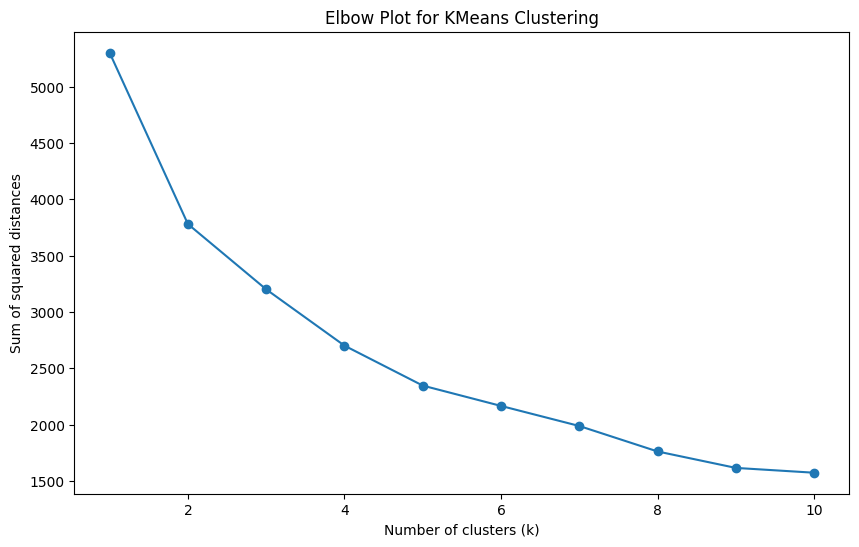

In [45]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

categorical_columns = ['Events', 'day_of_week', 'Season']
numerical_columns = gr_combined2.columns.difference(categorical_columns + ['date'])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ],
    remainder='passthrough'  
)

processed_data = preprocessor.fit_transform(gr_combined2.drop(columns=['date']))

pca = PCA(n_components=5)
pca_data = pca.fit_transform(processed_data)

sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Plot for KMeans Clustering')
plt.show()

The elbow plot indicates that k=2 is the optimal number of clusters, as the reduction in the sum of squared distances is most significant from 1 to 2.

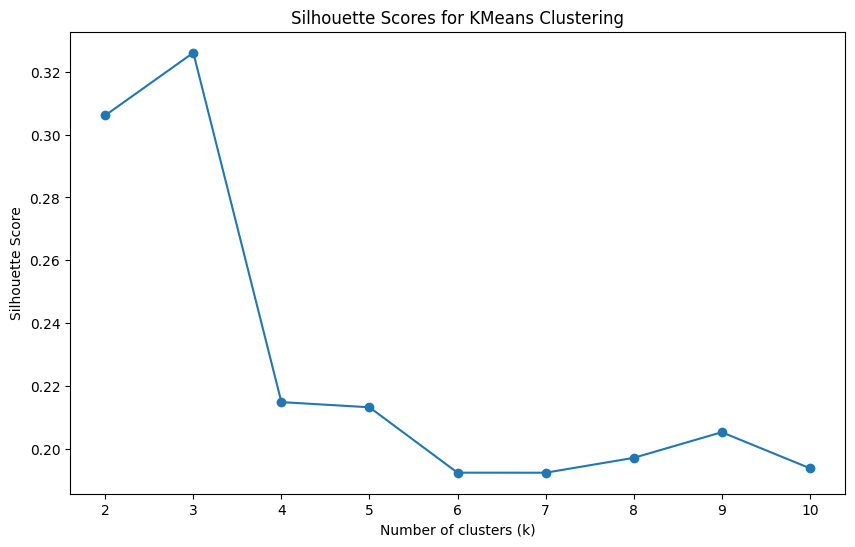

In [46]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette scores for different values of k
silhouette_scores = []
k_values = range(2, 11)  # Silhouette score is not defined for k=1
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_data)
    silhouette_avg = silhouette_score(pca_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for KMeans Clustering')
plt.show()

The silhouette plot indicates that k=3 yields the highest silhouette score. 

Therefore, we will proceed with k=3 for the KMeans algorithm.

In [47]:
categorical_columns = ['day_of_week', 'Season']
numerical_columns = gr_combined2.columns.difference(categorical_columns + ['date', 'Events', 'Mean TemperatureC', 'Precipitationmm'])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ],
    remainder='passthrough'  # Keep the remaining columns as they are
)

pca = PCA(n_components=5)
pca_transformed = pca.fit_transform(preprocessor.fit_transform(gr_combined2.drop(columns=['date', 'Events', 'Mean TemperatureC', 'Precipitationmm'])))

kmeans_3 = KMeans(n_clusters=3, random_state=42)
clusters_3 = kmeans_3.fit_predict(pca_transformed)

df_clusters_3 = gr_combined2.copy()
df_clusters_3['Cluster_k3'] = clusters_3

In [48]:
df_clusters_3

,date,L,M,S,XL,XXL,Chicken,Classic,Supreme,Veggie,price,Chicken_L,Chicken_M,Chicken_S,Classic_L,Classic_M,Classic_S,Classic_XL,Classic_XXL,Supreme_L,Supreme_M,Supreme_S,Veggie_L,Veggie_M,Veggie_S,day_of_week,Events,Mean TemperatureC,Precipitationmm,Season,Cluster_k3
0,2015-01-01,71.0,47.0,42.0,1.0,0.0,36.0,46.0,39.0,40.0,2697.85,21.0,10.0,5.0,12.0,15.0,18.0,1.0,0.0,16.0,15.0,8.0,22.0,7.0,11.0,Thursday,Sunny,1,0.00,Winter,1
1,2015-01-02,74.0,35.0,50.0,1.0,0.0,31.0,55.0,43.0,31.0,2643.15,12.0,10.0,9.0,18.0,12.0,24.0,1.0,0.0,24.0,8.0,11.0,20.0,5.0,6.0,Friday,Sunny,4,0.00,Winter,1
2,2015-01-03,62.0,51.0,37.0,4.0,0.0,39.0,46.0,32.0,37.0,2596.15,21.0,11.0,7.0,10.0,14.0,18.0,4.0,0.0,11.0,13.0,8.0,20.0,13.0,4.0,Saturday,Rain-Snow,3,18.03,Winter,1
3,2015-01-04,39.0,36.0,31.0,0.0,0.0,28.0,26.0,28.0,24.0,1755.45,13.0,11.0,4.0,9.0,8.0,9.0,0.0,0.0,9.0,9.0,10.0,8.0,8.0,8.0,Sunday,Rain,9,7.62,Winter,0
4,2015-01-05,44.0,45.0,32.0,0.0,0.0,27.0,37.0,28.0,29.0,1994.95,9.0,16.0,2.0,10.0,8.0,19.0,0.0,0.0,10.0,10.0,8.0,15.0,11.0,3.0,Monday,Sunny,2,0.00,Winter,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,2015-12-21,42.0,49.0,37.0,0.0,0.0,31.0,45.0,27.0,25.0,2063.45,14.0,13.0,4.0,13.0,15.0,17.0,0.0,0.0,7.0,14.0,6.0,8.0,7.0,10.0,Monday,Sunny,9,0.00,Winter,0
328,2015-12-22,45.0,37.0,29.0,0.0,0.0,28.0,26.0,25.0,32.0,1834.70,11.0,10.0,7.0,7.0,7.0,12.0,0.0,0.0,9.0,9.0,7.0,18.0,11.0,3.0,Tuesday,Rain,14,4.83,Winter,0
329,2015-12-23,56.0,33.0,39.0,2.0,0.0,27.0,47.0,28.0,28.0,2175.30,20.0,4.0,3.0,13.0,13.0,19.0,2.0,0.0,12.0,7.0,9.0,11.0,9.0,8.0,Wednesday,Rain,14,39.37,Winter,0
330,2015-12-24,51.0,42.0,36.0,0.0,0.0,27.0,41.0,24.0,37.0,2100.85,14.0,8.0,5.0,13.0,9.0,19.0,0.0,0.0,5.0,12.0,7.0,19.0,13.0,5.0,Thursday,Rain,20,0.25,Winter,0


In [49]:
cluster_3_means = df_clusters_3.groupby('Cluster_k3')[numerical_columns].mean()

In [50]:
cluster_3_means

,Chicken,Chicken_L,Chicken_M,Chicken_S,Classic,Classic_L,Classic_M,Classic_S,Classic_XL,Classic_XXL,L,M,S,Supreme,Supreme_L,Supreme_M,Supreme_S,Veggie,Veggie_L,Veggie_M,Veggie_S,XL,XXL,price
Cluster_k3,,,,,,,,,,,,,,,,,,,,,,,,
0,28.458515,12.733624,9.982533,5.742358,37.724891,10.157205,10.537118,15.650655,1.379913,0.000000,48.048035,40.244541,37.021834,30.829694,11.641921,10.449782,8.737991,29.681223,13.515284,9.275109,6.890830,1.379913,0.000000,2087.265066
1,36.207792,15.779221,12.883117,7.545455,50.090909,14.077922,13.961039,20.129870,1.909091,0.012987,63.259740,52.883117,48.103896,39.714286,14.948052,13.558442,11.207792,40.155844,18.454545,12.480519,9.220779,1.909091,0.012987,2734.872727
2,28.653846,13.153846,10.000000,5.500000,41.846154,11.192308,10.846154,17.038462,1.769231,1.000000,51.769231,39.653846,37.384615,32.269231,13.269231,10.769231,8.230769,28.807692,14.153846,8.038462,6.615385,1.769231,1.000000,2204.371154


In [51]:
cluster_3_means.to_clipboard()

In [52]:
categorical_columns = ['Events', 'day_of_week', 'Season']
for column in categorical_columns:
    print(f"Value counts for {column} grouped by Cluster_k2:")
    print(df_clusters_3.groupby('Cluster_k3')[column].value_counts())
    print("\n")

Value counts for Events grouped by Cluster_k2:
Cluster_k3  Events       
0           Sunny            159
            Rain              45
            Fog-Rain          10
            Snow               8
            Fog-Rain-Snow      4
            Rain-Snow          2
            Fog-Snow           1
1           Sunny             59
            Rain              13
            Fog-Rain           2
            Fog-Snow           1
            Rain-Snow          1
            Snow               1
2           Sunny             16
            Rain               7
            Fog-Snow           2
            Fog-Rain           1
Name: count, dtype: int64


Value counts for day_of_week grouped by Cluster_k2:
Cluster_k3  day_of_week
0           Sunday         44
            Wednesday      40
            Tuesday        38
            Monday         36
            Thursday       34
            Saturday       28
            Friday          9
1           Friday         38
            Saturday  

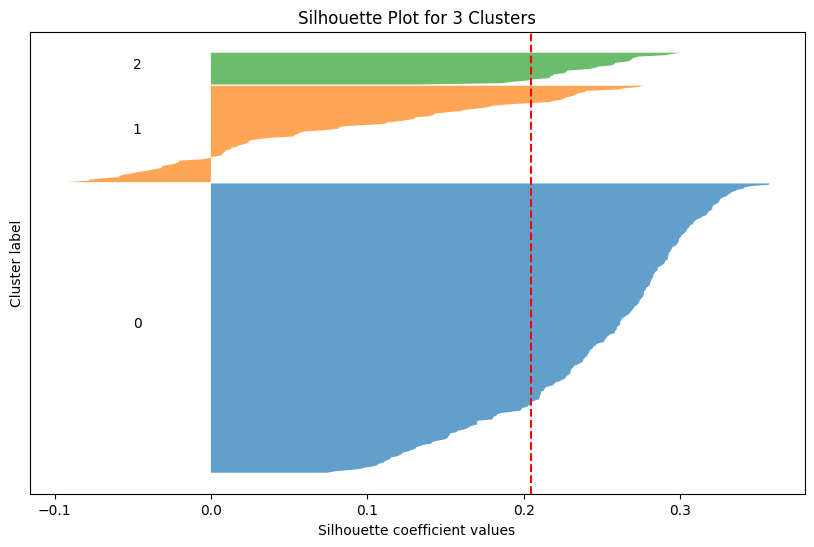

In [53]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

silhouette_vals = silhouette_samples(preprocessor.transform(gr_combined2.drop(columns=['date', 'Events', 'Mean TemperatureC', 'Precipitationmm'])), clusters_3)

silhouette_avg = silhouette_score(preprocessor.transform(gr_combined2.drop(columns=['date', 'Events', 'Mean TemperatureC', 'Precipitationmm'])), clusters_3)

fig, ax = plt.subplots(figsize=(10, 6))

y_lower, y_upper = 0, 0
n_clusters = len(np.unique(clusters_3))
for i in range(n_clusters):
    cluster_silhouette_vals = silhouette_vals[clusters_3 == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(i))
    y_lower += len(cluster_silhouette_vals)

ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.set_yticks([])
ax.set_title("Silhouette Plot for 3 Clusters")
plt.show()

This silhouette plot indicates a generally well-defined clustering structure for three clusters. Cluster 0 shows a strong silhouette score with values largely above the average silhouette score (red dashed line), suggesting well-separated groupings, while Clusters 1 and 2 also exhibit positive silhouette values, indicating reasonably good cohesion and separation across all clusters.

### Cluster 0
Average Price: $2,087.27

Key Observations:

Cluster 0 represents a moderate level of overall sales, with significant contributions from Chicken and Supreme pizzas, particularly larger sizes like Chicken_L (12.73) and Supreme_M (29.68).

Larger sizes (L, XL, XXL) contribute substantially to the sales figures, with Classic_L (10.16) and Supreme_L (10.45) being popular choices.

Smaller-sized pizzas and niche categories (e.g., Classic_XL, Classic_XXL) show minimal contribution to total sales, highlighting a preference for medium to large sizes.

Sales are highest on Sunday (44) and Wednesday (40), with activity spread throughout the week. Friday shows relatively low sales (9), indicating this cluster has less emphasis on weekend traffic compared to others.  

### Cluster 1
Average Price: $2,734.87

Key Observations:

Cluster 1 has higher sales overall, with prominent contributions from Classic and Supreme pizzas, especially larger sizes like Supreme_M (40.16) and Chicken_L (15.78).

Larger sizes (XL, XXL) show a notable increase in contribution compared to Cluster 0, and Supreme and Classic pizzas are popular across both large and medium sizes.

Smaller-sized pizzas, such as Veggie_S and Classic_S, contribute comparatively less, while larger premium pizzas continue to be the primary drivers of sales.

Sales are highest on Friday (38), emphasizing weekend demand, followed by Saturday (14). This cluster shows a preference for late-week and weekend purchases.

### Cluster 2
Average Price: $2,204.37

Key Observations:

Cluster 2 has moderate sales levels, with strong contributions from Classic pizzas and Chicken, particularly sizes like Chicken_L (13.15) and Supreme_L (10.77).

Large-sized pizzas (L, XL) also contribute significantly, though not as much as in Cluster 1, with more balanced contributions across small, medium, and large pizzas.

The smallest pizzas (e.g., Veggie_S, Classic_S) still contribute less, indicating that medium-sized orders are preferred.

Sales are spread across the week, with Tuesday (6) and Thursday (5) having the highest sales. The rest of the week shows lower activity, indicating a more even, mid-week focused sales trend.

Weather-wise, sales are highest during Sunny days (16), with lower activity during Rain (7) and other mixed weather events, suggesting that demand in this cluster is also influenced by favorable weather.

### Comparison Between Clusters
Cluster 1 stands out with the highest overall sales and a clear preference for larger, premium pizzas. Cluster 0 also performs well, particularly with larger pizzas, but shows more moderate sales compared to Cluster 1. Cluster 2 has balanced sales, with a strong contribution from medium-sized pizzas and more evenly spread sales throughout the week.

Cluster 0 sees most sales on weekends, while Cluster 1 is highly focused on Fridays, emphasizing weekend-driven purchases. Cluster 2 has more balanced sales across mid-week days, reflecting different customer patterns.

### Business Insights
The pizza store should focus marketing efforts on larger sizes of Chicken, Classic, and Supreme pizzas, as these are the top contributors in all clusters.

There is also an opportunity to increase the appeal of smaller-sized and niche pizzas, especially in Cluster 2, where contributions from these options are relatively balanced.

Promotions targeting weekends would benefit Cluster 0 and Cluster 1, while Cluster 2 could benefit from mid-week promotional deals.

#### Agglomerative Clustering

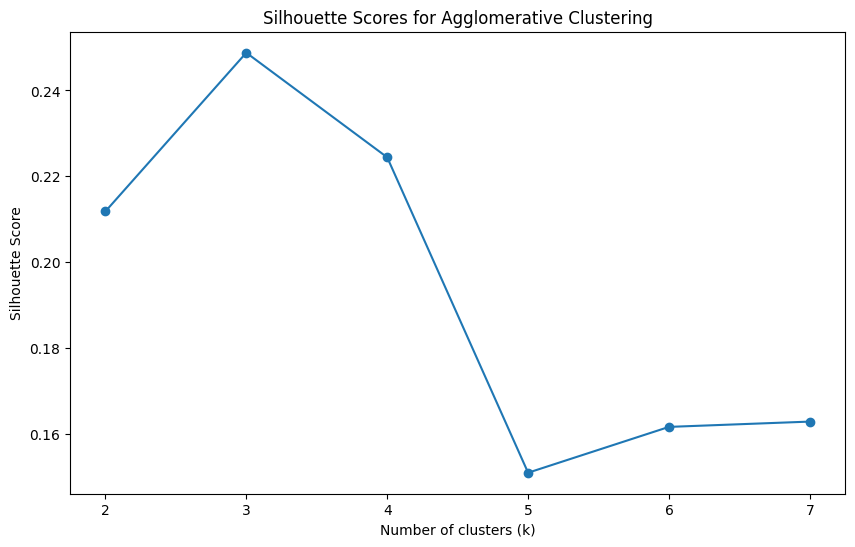

In [54]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

# Calculate the silhouette scores for different values of k
silhouette_scores = []
k_values = range(2, 8)  # Silhouette score for k from 2 to 7
for k in k_values:
    agg_cluster = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = agg_cluster.fit_predict(pca_transformed)
    silhouette_avg = silhouette_score(pca_transformed, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Agglomerative Clustering')
plt.show()

Agglomerative clustering also indicates that k=3 has the highest silhouette score.

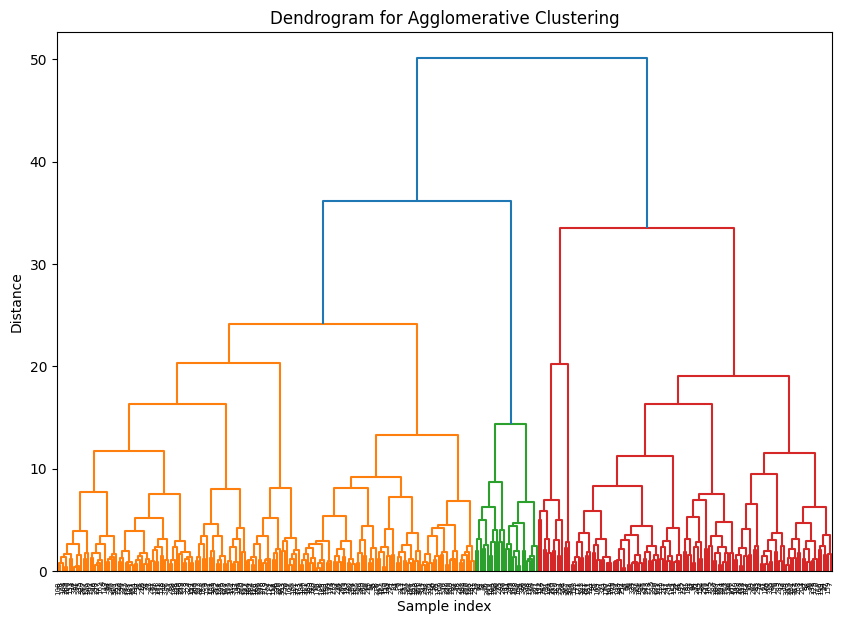

,date,L,M,S,XL,XXL,Chicken,Classic,Supreme,Veggie,price,Chicken_L,Chicken_M,Chicken_S,Classic_L,Classic_M,Classic_S,Classic_XL,Classic_XXL,Supreme_L,Supreme_M,Supreme_S,Veggie_L,Veggie_M,Veggie_S,day_of_week,Events,Mean TemperatureC,Precipitationmm,Season,Agg_Cluster
0,2015-01-01,71.0,47.0,42.0,1.0,0.0,36.0,46.0,39.0,40.0,2697.85,21.0,10.0,5.0,12.0,15.0,18.0,1.0,0.0,16.0,15.0,8.0,22.0,7.0,11.0,Thursday,Sunny,1,0.00,Winter,0
1,2015-01-02,74.0,35.0,50.0,1.0,0.0,31.0,55.0,43.0,31.0,2643.15,12.0,10.0,9.0,18.0,12.0,24.0,1.0,0.0,24.0,8.0,11.0,20.0,5.0,6.0,Friday,Sunny,4,0.00,Winter,0
2,2015-01-03,62.0,51.0,37.0,4.0,0.0,39.0,46.0,32.0,37.0,2596.15,21.0,11.0,7.0,10.0,14.0,18.0,4.0,0.0,11.0,13.0,8.0,20.0,13.0,4.0,Saturday,Rain-Snow,3,18.03,Winter,0
3,2015-01-04,39.0,36.0,31.0,0.0,0.0,28.0,26.0,28.0,24.0,1755.45,13.0,11.0,4.0,9.0,8.0,9.0,0.0,0.0,9.0,9.0,10.0,8.0,8.0,8.0,Sunday,Rain,9,7.62,Winter,1
4,2015-01-05,44.0,45.0,32.0,0.0,0.0,27.0,37.0,28.0,29.0,1994.95,9.0,16.0,2.0,10.0,8.0,19.0,0.0,0.0,10.0,10.0,8.0,15.0,11.0,3.0,Monday,Sunny,2,0.00,Winter,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,2015-12-21,42.0,49.0,37.0,0.0,0.0,31.0,45.0,27.0,25.0,2063.45,14.0,13.0,4.0,13.0,15.0,17.0,0.0,0.0,7.0,14.0,6.0,8.0,7.0,10.0,Monday,Sunny,9,0.00,Winter,1
328,2015-12-22,45.0,37.0,29.0,0.0,0.0,28.0,26.0,25.0,32.0,1834.70,11.0,10.0,7.0,7.0,7.0,12.0,0.0,0.0,9.0,9.0,7.0,18.0,11.0,3.0,Tuesday,Rain,14,4.83,Winter,1
329,2015-12-23,56.0,33.0,39.0,2.0,0.0,27.0,47.0,28.0,28.0,2175.30,20.0,4.0,3.0,13.0,13.0,19.0,2.0,0.0,12.0,7.0,9.0,11.0,9.0,8.0,Wednesday,Rain,14,39.37,Winter,1
330,2015-12-24,51.0,42.0,36.0,0.0,0.0,27.0,41.0,24.0,37.0,2100.85,14.0,8.0,5.0,13.0,9.0,19.0,0.0,0.0,5.0,12.0,7.0,19.0,13.0,5.0,Thursday,Rain,20,0.25,Winter,1


In [55]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

linked = linkage(pca_transformed, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

agg_cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
agg_clusters = agg_cluster.fit_predict(pca_transformed)

df_clusters_agg = gr_combined2.copy()
df_clusters_agg['Agg_Cluster'] = agg_clusters

df_clusters_agg

In [56]:
df_clusters_agg.groupby('Agg_Cluster')[numerical_columns].mean()

,Chicken,Chicken_L,Chicken_M,Chicken_S,Classic,Classic_L,Classic_M,Classic_S,Classic_XL,Classic_XXL,L,M,S,Supreme,Supreme_L,Supreme_M,Supreme_S,Veggie,Veggie_L,Veggie_M,Veggie_S,XL,XXL,price
Agg_Cluster,,,,,,,,,,,,,,,,,,,,,,,,
0,34.420635,15.158730,12.428571,6.833333,46.293651,12.682540,12.873016,18.634921,2.103175,0.0,59.023810,50.015873,43.904762,37.095238,14.214286,12.706349,10.174603,37.238095,16.968254,12.007937,8.261905,2.103175,0.0,2560.710317
1,27.547486,12.329609,9.491620,5.726257,36.955307,10.044693,10.357542,15.458101,1.094972,0.0,46.737430,38.743017,36.865922,30.150838,11.212291,10.167598,8.770950,28.787709,13.150838,8.726257,6.910615,1.094972,0.0,2027.926536
2,28.962963,13.185185,10.111111,5.666667,42.074074,11.296296,10.888889,17.111111,1.777778,1.0,52.481481,40.074074,37.888889,32.814815,13.481481,10.962963,8.370370,29.370370,14.518519,8.111111,6.740741,1.777778,1.0,2230.896296


In [57]:
df_clusters_agg.groupby('Agg_Cluster')[numerical_columns].mean().to_clipboard()

In [58]:
categorical_columns = ['Events', 'day_of_week', 'Season']
for column in categorical_columns:
    print(f"Value counts for {column} grouped by Cluster:")
    print(df_clusters_agg.groupby('Agg_Cluster')[column].value_counts())
    print("\n")

Value counts for Events grouped by Cluster:
Agg_Cluster  Events       
0            Sunny             92
             Rain              19
             Fog-Rain           6
             Snow               6
             Fog-Rain-Snow      1
             Fog-Snow           1
             Rain-Snow          1
1            Sunny            126
             Rain              38
             Fog-Rain           6
             Fog-Rain-Snow      3
             Snow               3
             Rain-Snow          2
             Fog-Snow           1
2            Sunny             16
             Rain               8
             Fog-Snow           2
             Fog-Rain           1
Name: count, dtype: int64


Value counts for day_of_week grouped by Cluster:
Agg_Cluster  day_of_week
0            Friday         40
             Saturday       26
             Thursday       18
             Monday         15
             Wednesday      14
             Tuesday        10
             Sunday          

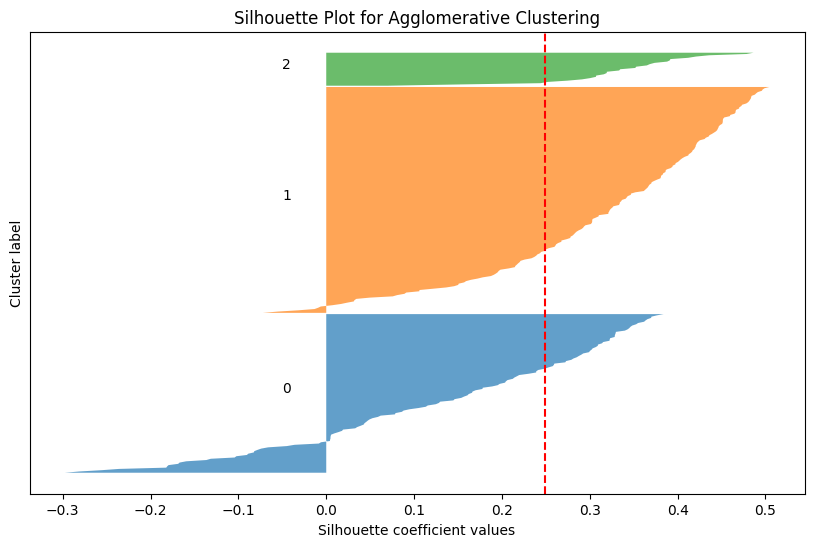

In [59]:
silhouette_vals = silhouette_samples(pca_transformed, df_clusters_agg['Agg_Cluster'])

silhouette_avg = silhouette_score(pca_transformed, df_clusters_agg['Agg_Cluster'])

# Create a silhouette plot
fig, ax = plt.subplots(figsize=(10, 6))

y_lower, y_upper = 0, 0
n_clusters = len(np.unique(df_clusters_agg['Agg_Cluster']))
for i in range(n_clusters):
    cluster_silhouette_vals = silhouette_vals[df_clusters_agg['Agg_Cluster'] == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(i))
    y_lower += len(cluster_silhouette_vals)

ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.set_yticks([])
ax.set_title("Silhouette Plot for Agglomerative Clustering")
plt.show()

Looking at the silhouette plots, we believe the clusters created by agglomerative approach are a better fit.

#### Cluster Analysis

#### Cluster 0
Average Price: $2,560.71

Key Observations:

Significant contributions from Chicken and Classic pizzas. Larger sizes such as Chicken_L (15.16) and Classic_L (12.68) show substantial sales, indicating a preference for bigger portions.
Supreme pizzas are also popular, with Supreme_M (12.71) and Supreme_S (10.17) contributing to the sales.
Smaller-sized items (like Classic_XL and Classic_XXL) have minimal sales, indicating less interest in extra-large sizes.

Sales are highest on Friday (40), followed by Saturday (26) and Thursday (18), indicating mid-week to weekend focus.

#### Cluster 1
Average Price: $2,027.93

Key Observations:

Classic and Supreme pizzas are the most prominent contributors to sales.
Larger sizes, particularly Supreme_M (10.17) and Chicken_L (12.33), are popular among this cluster.
Veggie pizzas, particularly Veggie_L (13.15), are also favored, which could reflect a growing preference for vegetarian options.
Smaller-sized items, such as Veggie_S and Classic_S, have lower sales contributions, while larger sizes remain the primary sales drivers.

Sunday (42) is the top sales day, indicating a preference for late-week purchases, followed closely by Tuesday (32) and Wednesday (30).

#### Cluster 2
Average Price: $2,230.90

Key Observations:

Balanced contributions from Chicken and Classic pizzas.
Large-sized pizzas such as Chicken_L (13.19) and Supreme_L (13.48) are significant contributors, while medium-sized options also show strong performance.
Smaller items, such as Veggie_S and Classic_S, contribute the least, emphasizing a customer preference for medium to large sizes.

Sales are spread throughout the week, with Tuesday (7) and Thursday (5) being the top-performing days, suggesting a mid-week focus. The balanced sales pattern suggests opportunities for mid-week promotional deals, especially targeting Tuesday and Thursday.

#### Comparison Between Clusters
Cluster 1 stands out as the highest in sales with significant contributions from larger-sized pizzas, particularly Classic and Supreme varieties.

Cluster 0 has moderate sales, with a focus on larger Chicken and Classic pizzas, similar to Cluster 1 but at a more moderate level.

Cluster 2 features balanced sales across medium and large pizzas, emphasizing a steady, mid-week demand rather than the weekend-driven sales seen in other clusters.

#### Business Insights Summary
Focus marketing efforts on larger sizes of Chicken, Classic, and Supreme pizzas, as these are the top contributors across all clusters.

Consider enhancing the appeal of vegetarian options, particularly in Cluster 1, where Veggie pizzas have notable sales.

Weekend promotions targeting Cluster 0 and Cluster 1 would maximize sales, while mid-week offers could attract more sales from Cluster 2.